In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.filter import resample, filter_data
from scipy.signal import find_peaks, detrend, periodogram
from scipy.interpolate import splrep, splev

data = pd.read_csv(r'C:\Users\Mahe\Desktop\HTIC Signal Processing Task\ECG 1.csv')

#Select a window of 5000 samples consisiting of 12.5 seconds of data

start = 200000

end = 205000

data = data[start:end]

#sampling frequency

sampling_freq = 400

window = (end - start)/ sampling_freq

#Normalize the data

data = (data - data.mean())/data.std()

data = data.astype(float)

print(data.shape)

#Filter data to remove non-respiratory frequencies

data = filter_data(data, sampling_freq, 2, 40, verbose=0)

#Detect R-R peaks

data = np.squeeze(data)

print(data.shape)

(5000, 1)


<ipython-input-177-6098a5bfa8b4>:34: RuntimeWarning: filter_length (661) is longer than the signal (1), distortion is likely. Reduce filter length or filter a longer signal.
  data = filter_data(data, sampling_freq, 2, 40, verbose=0)


(5000,)


[  26  306  590  894 1206 1502 1782 2062 2326 2575 2826 3070 3318 3562
 3806 4046 4290 4538 4802]


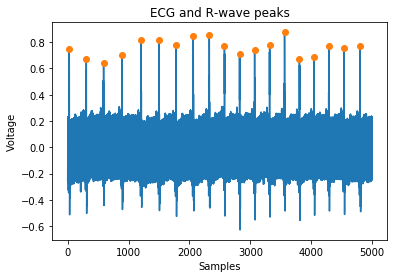

In [178]:
#Find R-wave peaks

rr = find_peaks(data, distance= 40, height = 0.5)

print(rr[0])

rr = rr[0]

plt.figure(1)

plt.plot(data)

plt.plot(rr, data[rr], 'o')

plt.title('ECG and R-wave peaks')

plt.xlabel('Samples')

_ = plt.ylabel('Voltage')

# R-R interval in ms

rr = (rr / sampling_freq) * 1000

rri = np.diff(rr)

Mean HR: 90.61 beats per minute


Text(0, 0.5, 'Heart rate (BPM)')

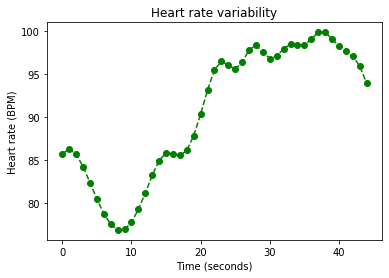

In [179]:
# Function to interpolate r-r intervals to compute HR 

def cubicSplineInterpolation(rri, up_freq):
   
    rri_time = np.cumsum(rri) / 1000
    
    time_rri = rri_time - rri_time[0]
    
    #Change time values according to interpolated r-r values
    
    time_rri_interp = np.arange(0, time_rri[-1], 1 / float(up_freq))
    
    tck = splrep(time_rri, rri, s=0)
    
    rri_interp = splev(time_rri_interp, tck, der=0)
    
    return rri_interp

#Upsampling of R-R intervals to make sampling more regular
   
up_freq = 4

rri_interp = cubicSplineInterpolation(rri, up_freq)
 
hr = 1000 * (60 / rri_interp)

print('Mean HR: %.2f beats per minute' % np.mean(hr))

plt.figure(2)

plt.plot(hr, linestyle = '--', marker = 'o', color = 'g')

plt.title('Heart rate variability')

plt.xlabel('Time (seconds)')

plt.ylabel('Heart rate (BPM)')


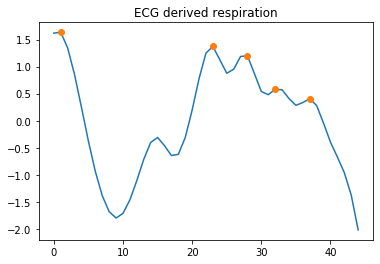

In [180]:
# Detrend and normalize the HR to get ECG derived respiratory signal

edr = detrend(hr)

edr = (edr - edr.mean()) / edr.std()

# Find respiratory peaks

resp_peaks, _ = find_peaks(edr, height = 0, distance = up_freq)

# Convert to seconds

resp_peaks_diff = np.diff(resp_peaks) / up_freq

# Plot the EDR waveform

plt.figure(3)

plt.plot(edr, '-')

plt.plot(resp_peaks, edr[resp_peaks], 'o')

_ = plt.title('ECG derived respiration')

Mean respiratory rate: 0.40 Hz
Mean respiratory period: 2.50 seconds
No. of breaths per minute: 24.00 
Maximum frequency : 0.09 Hz


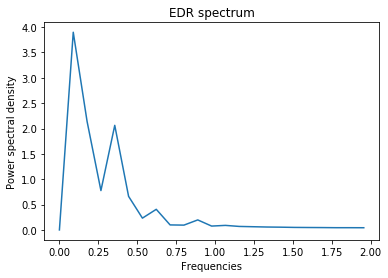

In [181]:
# Extract the mean respiratory rate over the selected window

mresprate = resp_peaks.size / window

print('Mean respiratory rate: %.2f Hz' % mresprate)

print('Mean respiratory period: %.2f seconds' % (1 / mresprate))

print('No. of breaths per minute: %.2f ' % (60*mresprate))

"""
Calculating respiratory rate using FFT of the ECG derived respiration
"""

freqs, psd = periodogram(edr, up_freq)

plt.figure(4)

plt.plot(freqs, psd)

plt.ylabel('Power spectral density')

plt.xlabel('Frequencies')

plt.title('EDR spectrum')

print('Maximum frequency : %.2f Hz' % freqs[np.argmax(psd)])
